**CUSTOMER CHURN PREDICTION**

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [99]:
df = pd.read_csv("/content/customer_churn.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (500, 9)


,CustomerID,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,PaperlessBilling,SeniorCitizen,Churn
0,C00001,6,64,1540,One year,Credit Card,No,1,0
1,C00002,21,113,1753,Month-to-month,Electronic Check,Yes,1,0
2,C00003,27,31,1455,Two year,Credit Card,No,1,0
3,C00004,53,29,7150,Month-to-month,Electronic Check,No,1,0
4,C00005,16,185,1023,One year,Electronic Check,No,1,0


In [100]:
df.info()
df.describe()

# Churn distribution
df['Churn'].value_counts(normalize=True) * 100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        500 non-null    object
 1   Tenure            500 non-null    int64 
 2   MonthlyCharges    500 non-null    int64 
 3   TotalCharges      500 non-null    int64 
 4   Contract          500 non-null    object
 5   PaymentMethod     500 non-null    object
 6   PaperlessBilling  500 non-null    object
 7   SeniorCitizen     500 non-null    int64 
 8   Churn             500 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 35.3+ KB


,proportion
Churn,
0,89.4
1,10.6


In [101]:
df.isnull().sum()

df = df.dropna()


In [102]:
print(df.columns)


Index(['CustomerID', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'Contract',
       'PaymentMethod', 'PaperlessBilling', 'SeniorCitizen', 'Churn'],
      dtype='object')


In [103]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Churn_encoded'] = le.fit_transform(df['Churn'])

df[['Churn', 'Churn_encoded']].head()


,Churn,Churn_encoded
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [104]:
df_encoded = pd.get_dummies(
    df,
    columns=['Contract'],
    drop_first=True
)


In [105]:
df_encoded['Churn_binary'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})


In [106]:
minmax_scaler = MinMaxScaler()

df_encoded[['MonthlyCharges_minmax']] = minmax_scaler.fit_transform(
    df_encoded[['MonthlyCharges']]
)


In [107]:
std_scaler = StandardScaler()

df_encoded[['MonthlyCharges_std']] = std_scaler.fit_transform(
    df_encoded[['MonthlyCharges']]
)


In [108]:
Q1 = df_encoded['MonthlyCharges'].quantile(0.25)
Q3 = df_encoded['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

df_encoded['Outlier_IQR'] = (
    (df_encoded['MonthlyCharges'] < (Q1 - 1.5 * IQR)) |
    (df_encoded['MonthlyCharges'] > (Q3 + 1.5 * IQR))
)


In [109]:
from scipy.stats import zscore

df_encoded['MonthlyCharges_zscore'] = zscore(df_encoded['MonthlyCharges'])
df_encoded['Outlier_Zscore'] = abs(df_encoded['MonthlyCharges_zscore']) > 3


In [110]:
# 1. Customer Lifetime Value
df_encoded['Customer_Lifetime_Value'] = df_encoded['MonthlyCharges'] * df_encoded['Tenure']

# 2. Average Monthly Spend
df_encoded['Avg_Monthly_Spend'] = df_encoded['MonthlyCharges'] / (df_encoded['Tenure'] + 1)

# 3. High Value Customer
df_encoded['High_Value_Customer'] = df_encoded['Customer_Lifetime_Value'] > df_encoded['Customer_Lifetime_Value'].median()

# 4. Long Term Customer
df_encoded['Long_Term_Customer'] = df_encoded['Tenure'] > 12

# 5. Payment Efficiency
df_encoded['Payment_Efficiency'] = df_encoded['MonthlyCharges'] / df_encoded['Customer_Lifetime_Value']


In [111]:
numeric_df = df_encoded.select_dtypes(include=['int64', 'float64'])


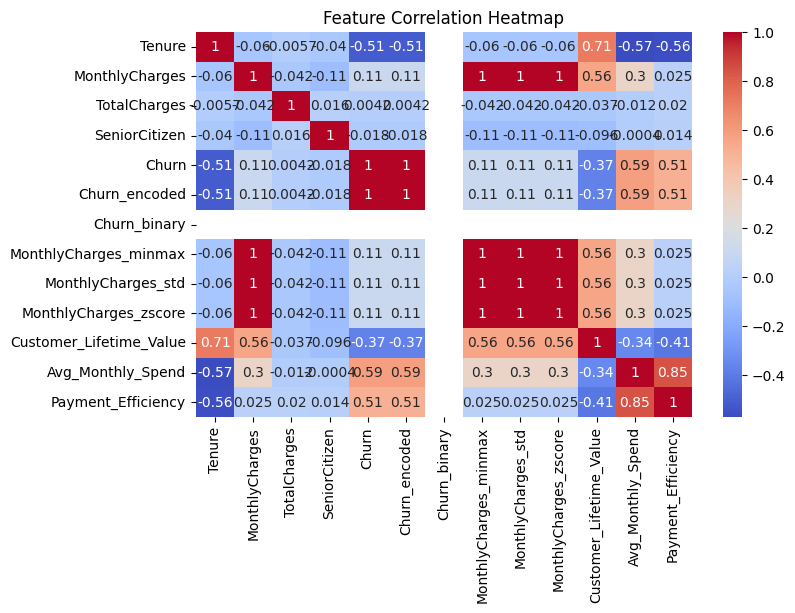

In [112]:
plt.figure(figsize=(8,5))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()


In [113]:
X = df_encoded.drop(['Churn', 'Churn_binary'], axis=1)

X_numeric = X.select_dtypes(include=['int64', 'float64'])
y = df_encoded['Churn_binary']


In [114]:
df_encoded['Churn_binary'].isna().sum()


np.int64(500)

In [115]:
df_fs = df_encoded.dropna(subset=['Churn_binary'])

X_numeric = df_fs.select_dtypes(include=['int64', 'float64']).drop(
    columns=['Churn_binary'], errors='ignore'
)
y = df_fs['Churn_binary']


In [116]:
df['Churn'].unique()


array([0, 1])

In [117]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded['Churn_binary'] = le.fit_transform(df_encoded['Churn'])


In [118]:
df_encoded['Churn_binary'].isna().sum()


np.int64(0)

In [119]:
# Keep only numeric features
X_numeric = df_encoded.select_dtypes(include=['int64', 'float64']).drop(
    columns=['Churn_binary'], errors='ignore'
)

y = df_encoded['Churn_binary']

print(X_numeric.shape)
print(y.shape)


(500, 12)
(500,)


In [120]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X_numeric, y)

selected_features = X_numeric.columns[selector.get_support()]
selected_features


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Index(['Tenure', 'Churn', 'Churn_encoded', 'Avg_Monthly_Spend',
       'Payment_Efficiency'],
      dtype='object')

In [121]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Churn_binary'] = le.fit_transform(df['Churn'])


In [122]:
numeric_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['Contract', 'PaymentMethod', 'PaperlessBilling', 'SeniorCitizen']


In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000))
    ]
)


In [124]:
X = df.drop(['Churn', 'Churn_binary'], axis=1)
y = df['Churn_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [125]:
pipeline.fit(X_train, y_train)

print("Pipeline built and tested successfully")


Pipeline built and tested successfully


In [126]:
print("""
WEEK 10 SUMMARY:
- 3 Encoding methods applied
- 2 Scaling techniques used
- Outliers handled using IQR & Z-score
- 5+ engineered features created
- Feature selection performed
- End-to-end preprocessing pipeline built
""")



WEEK 10 SUMMARY:
- 3 Encoding methods applied
- 2 Scaling techniques used
- Outliers handled using IQR & Z-score
- 5+ engineered features created
- Feature selection performed
- End-to-end preprocessing pipeline built

